In [3]:
# default_exp engineering.concurrency

%reload_ext autoreload
%autoreload 2

# 并发
并发分为两种: 多进程和多线程。

现在的处理器有多个核心，并发的目的是充分利用处理器的性能，使得多个任务并发执行，以节约程序运行时间。

多进程，python提供了multiprocessing模块

多线程，python提供了threading模块

## 术语解释
### Global Interpreter Lock -- 全局解释器锁
https://docs.python.org/zh-cn/3.7/glossary.html#term-global-interpreter-lock

CPython 解释器所采用的一种机制，它确保同一时刻只有一个线程在执行 Python bytecode。此机制通过设置对象模型（包括 dict 等重要内置类型）针对并发访问的隐式安全简化了 CPython 实现。给整个解释器加锁使得解释器多线程运行更方便，其代价则是牺牲了在多处理器上的并行性。

### CPU 密集型任务和 IO 密集型任务
* CPU/计算密集型  
顾名思义就是应用需要非常多的CPU计算资源，在多核CPU时代，我们要让每一个CPU核心都参与计算，将CPU的性能充分利用起来，这样才算是没有浪费服务器配置，如果在非常好的服务器配置上还运行着单线程程序那将是多么重大的浪费。对于计算密集型的应用，完全是靠CPU的核数来工作，所以为了让它的优势完全发挥出来，避免过多的线程上下文切换，选择多进程

* IO密集型  
 对于IO密集型的应用，就很好理解了，我们现在做的开发大部分都是WEB应用，涉及到大量的网络传输，不仅如此，与数据库，与缓存间的交互也涉及到IO，一旦发生IO，线程就会处于等待状态，当IO结束，数据准备好后，线程才会继续执行。因此从这里可以发现，对于IO密集型的应用，我们可以多设置一些线程池中线程的数量，这样就能让在等待的这段时间内，线程可以去做其它事，提高并发处理效率。

 那么这个线程池的数据量是不是可以随便设置呢？当然不是的，请一定要记得，线程上下文切换是有代价的。目前总结了一套公式，对于IO密集型应用：

线程数 =  CPU核心数/(1-阻塞系数)

 这个阻塞系数一般为0.8~0.9之间，也可以取0.8或者0.9。

# multiprocessing
https://docs.python.org/zh-cn/3.7/library/multiprocessing.html

https://www.bilibili.com/video/BV1EE411F7vV?p=5

multiprocessing 是一个用与 threading 模块相似API的支持产生进程的包。 multiprocessing 包同时提供本地和远程并发，使用子进程代替线程，有效避免 Global Interpreter Lock 带来的影响。因此， multiprocessing 模块允许程序员充分利用机器上的多个核心。Unix 和 Windows 上都可以运行。

In [22]:
import multiprocessing

In [23]:
# 获取CPU核数
multiprocessing.cpu_count()

4

## Process创建子进程并执行
有两种方式
* 通过传递参数的方式创建
* 通过继承的方式创建

In [5]:
from multiprocessing import Process

In [ ]:
Process(
    group=None,
    target=None,
    name=None,
    args=(),
    kwargs={},
    *,
    daemon=None,
)

### 通过传递参数的方式创建
即通过把方法名传给Process的target参数

In [6]:
def run_proc():
    print('子进程运行中...')

p = Process(target = run_proc)

p.start()

子进程运行中...


#### 传递方法参数

In [7]:
def run_proc(a, age, **kwargs):
    print(a,age, kwargs)
    print('子进程运行中...')
    
p = Process(target=run_proc, args=('a1',12,), kwargs={'key1':12})

p.start()

a1 12 {'key1': 12}
子进程运行中...


### 使用继承方式创建进程
继承Process类，重写run方法

In [10]:
#export
class ClockProcess(Process):
    def __init__(self, interval):
        Process.__init__(self)
        self.interval = interval
    def run(self):
        from time import sleep
        print('子进程开始')
        sleep(self.interval)
        print('子进程结束')

In [11]:
p = ClockProcess(2)
p.start()
p.join()
print('主进程结束')

子进程开始
子进程结束
主进程结束


### join(timeout=None)
当前的主进程要等待调用join方法的子进程终止后才会继续往下执行。 

如果timeout不为None，则主进程等待timeout秒后，如果子进程仍没有执行完，则主进程继续往下执行  
Docstring: Wait until child process terminates

In [17]:
from time import sleep

In [19]:
def run_proc(a, age, **kwargs):
    print(a,age, kwargs)
    sleep(1)
    print('子进程运行中...')
    
p = Process(target=run_proc, args=('a1',12,), kwargs={'key1':12})

p.start()
print('主进程执行完')

主进程执行完
a1 12 {'key1': 12}
子进程运行中...


### name pid is_alive()

In [26]:
def run_proc(a, age, **kwargs):
    print(a,age, kwargs)
    sleep(1)
    print('子进程运行中...')
    
p = Process(target=run_proc, args=('a1',12,), kwargs={'key1':12})
print(p.pid, p.name, p.is_alive())  # 进程未启动时pid为None
p.start()
print(p.pid, p.name, p.is_alive())
p.join()
print(p.pid, p.name, p.is_alive())
print('主进程执行完')
print(p.pid, p.name, p.is_alive())

None Process-17 False
a1 12 {'key1': 12}
2836 Process-17 True
子进程运行中...
2836 Process-17 False
主进程执行完
2836 Process-17 False


## 进程池Pool

进程池的作用是方便进程创建和管理、方便限制进程的数量。

Pool可以提供指定数量的进程，供用户调用，当有新的请求提交到pool中时，如果pool还没有满，那么就创建一个新的进程来执行该请求；如果pool中的进程数已经达到规定的最大值，那么请求就会等待，直到pool中有进程结束，才会创建新的进程。 Pool的语法格式如下：

    Pool(processes=None, initializer=None, initargs=(), maxtasksperchild=None)
    
其中processes: 进程数，如果为None，则为cpu_count()的值。initializer是每个进程启动时要执行的可调用对象。initargs是传递给initializer的参数元组。

### apply和map的区别是： 
apply可以接收任意参数，而map只能接收iterable参数

apply没有返回值，map返回list

In [15]:
from multiprocessing import Pool
from time import sleep

### pool.apply(func, args=(), kwds={})

    Docstring:
    Equivalent of `func(*args, **kwds)`.
    Pool must be running.
    使用 args 参数以及 kwds 命名参数调用 func , 它会返回结果前阻塞。这种情况下，apply_async() 更适合并行化工作。
    另外 func 只会在一个进程池中的一个工作进程中执行。


In [24]:
def func(msg):
    print('start', msg)
    sleep(3)
    print('end', msg)
    return msg
pool = Pool(3)
for i in range(5):
    msg = f'hello, {i}'
    # 执行时会阻塞，等待程序返回后才会继续
    t = pool.apply(func, (msg,))
    print(t)
print('pool begin to close')    
pool.close()  # 进程池关闭之后不再接收新的请求
print('pool end to close')    
# 调用join之前，先调用close函数，否则会报错
# 执行完close后不会有新的进程加入到pool，join函数等待所有子进程结束
pool.join()
print('主进程结束')    


start hello, 0
end hello, 0
start hello, 1
hello, 0
end hello, 1
start hello, 2
hello, 1
end hello, 2
start hello, 3
hello, 2
end hello, 3
start hello, 4
hello, 3
end hello, 4
hello, 4
pool begin to close
pool end to close
主进程结束


### pool.apply_async(
    func,
    args=(),
    kwds={},
    callback=None,
    error_callback=None,
)

    Docstring: Asynchronous version of `apply()` method.
    
    apply() 方法的一个变种，返回一个结果对象。

    如果指定了 callback , 它必须是一个接受单个参数的可调用对象。当执行成功时， callback 会被用于处理执行后的返回结果，否则，调用 error_callback 。

    如果指定了 error_callback , 它必须是一个接受单个参数的可调用对象。当目标函数执行失败时， 会将抛出的异常对象作为参数传递给 error_callback 执行。

    回调函数应该立即执行完成，否则会阻塞负责处理结果的线程。

In [18]:
def func(msg):
    print('start', msg)
    sleep(3)
    print('end', msg)
# pool = Pool(3)
pool = Pool()
for i in range(5):
    msg = f'hello, {i}'
    
    pool.apply_async(func, (msg,))
print('pool begin to close')    
pool.close()  # 进程池关闭之后不再接收新的请求
print('pool end to close')    
# 调用join之前，先调用close函数，否则会报错
# 执行完close后不会有新的进程加入到pool，join函数等待所有子进程结束
pool.join()
print('主进程结束')    


start hello, 0
start hello, 2
start hello, 1
start hello, 3
pool begin to close
pool end to close
end hello, 2
end hello, 3
end hello, 0
end hello, 1
start hello, 4
end hello, 4
主进程结束


### map(func, iterable[, chunksize])

    内置 map() 函数的并行版本 (但它只支持一个 iterable 参数，对于多个可迭代对象请参阅 starmap())。 它会保持阻塞直到获得结果。

    这个方法会将可迭代对象分割为许多块，然后提交给进程池。可以将 chunksize 设置为一个正整数从而（近似）指定每个块的大小可以。

    注意对于很长的迭代对象，可能消耗很多内存。可以考虑使用 imap() 或 imap_unordered() 并且显示指定 chunksize 以提升效率。

In [26]:
def func(msg):
    print('start', msg)
    sleep(3)
    print('end', msg)
    return f'r---------{msg}'

a = [f'hello, {i}' for i in range(10)]
pool = Pool(3)
t = pool.map(func, a)
print(t)
    
print('pool begin to close')    
pool.close()  # 进程池关闭之后不再接收新的请求
print('pool end to close')    
# 调用join之前，先调用close函数，否则会报错
# 执行完close后不会有新的进程加入到pool，join函数等待所有子进程结束
pool.join()
print('主进程结束')    

start hello, 0
start hello, 2
start hello, 1
end hello, 0
end hello, 2
end hello, 1
start hello, 3
start hello, 4
start hello, 5
end hello, 3
end hello, 4
end hello, 5
start hello, 6
start hello, 7
start hello, 8
end hello, 6
end hello, 7
end hello, 8
start hello, 9
end hello, 9
['r---------hello, 0', 'r---------hello, 1', 'r---------hello, 2', 'r---------hello, 3', 'r---------hello, 4', 'r---------hello, 5', 'r---------hello, 6', 'r---------hello, 7', 'r---------hello, 8', 'r---------hello, 9']
pool begin to close
pool end to close
主进程结束


### map_async(func, iterable[, chunksize[, callback[, error_callback]]])

    和 map() 方法类似，但是返回一个multiprocessing.pool.MapResult对象。

    如果指定了 callback , 它必须是一个接受单个参数的可调用对象。当执行成功时， callback 会被用于处理执行后的返回结果，否则，调用 error_callback 。

    如果指定了 error_callback , 它必须是一个接受单个参数的可调用对象。当目标函数执行失败时， 会将抛出的异常对象作为参数传递给 error_callback 执行。

    回调函数应该立即执行完成，否则会阻塞负责处理结果的线程。

In [31]:
def func(msg):
    print('start', msg)
    sleep(3)
    print('end', msg)
    return f'r---------{msg}'

a = [f'hello, {i}' for i in range(10)]
pool = Pool(3)
t = pool.map_async(func, a).get()  # 通过get方法获取返回值
print(t)
    
print('pool begin to close')    
pool.close()  # 进程池关闭之后不再接收新的请求
print('pool end to close')    
# 调用join之前，先调用close函数，否则会报错
# 执行完close后不会有新的进程加入到pool，join函数等待所有子进程结束
pool.join()
print(t)
print('主进程结束')    

start hello, 1
start hello, 0
start hello, 2
end hello, 1
end hello, 0
start hello, 3
end hello, 2
start hello, 4
start hello, 5
end hello, 4
end hello, 3
end hello, 5
start hello, 6
start hello, 7
start hello, 8
end hello, 7
end hello, 6
end hello, 8
start hello, 9
end hello, 9
['r---------hello, 0', 'r---------hello, 1', 'r---------hello, 2', 'r---------hello, 3', 'r---------hello, 4', 'r---------hello, 5', 'r---------hello, 6', 'r---------hello, 7', 'r---------hello, 8', 'r---------hello, 9']
pool begin to close
pool end to close
['r---------hello, 0', 'r---------hello, 1', 'r---------hello, 2', 'r---------hello, 3', 'r---------hello, 4', 'r---------hello, 5', 'r---------hello, 6', 'r---------hello, 7', 'r---------hello, 8', 'r---------hello, 9']
主进程结束


## 在自定义class使用多进程

Python是一个面向对象的编程语言，很多时候我们会将一些程序封装为一个类。但是在类中，以上方法就不好使了。比如

In [33]:
from multiprocessing import Pool
import time

class test:
    def __init__(self):
        self.a = range(10)
    def run(self):
        def f(x):
            time.sleep(1)
            print (x+1)
            return x+1
        pool = Pool(4)
        self.b = pool.map(f, self.a)
        pool.close()
        pool.join()

t = test()
t.run()
print(t.b)

AttributeError: Can't pickle local object 'test.run.<locals>.f'

但如果将multiprocessing换成multiprocessing.dummy，就不会报错。说白了，这还是因为多进程之前变量无法共享的问题，而多线程之间同处于一个进程，自然不会有这个问题。

同大多数多进程编程一样，为了在进程之间通信，需要建立Queue对象，不同的是，网上一般的教程是通过multiprocessing的Process函数结合循环语句，来启动多进程，而用Pool是失败的（除非用multiprocessing.Manager.Queue，参考这篇文章），而gensim使用了Pool的一个技巧，还是可以通过Pool来直接启动多进程，果然高手的作品就是不一样。参考代码如下

In [35]:
from multiprocessing import Pool,Queue
import time

class test:
    def __init__(self):
        self.a = range(10)
    def run(self):
        in_queue, out_queue = Queue(), Queue()
        for i in self.a:
            in_queue.put(i)
        def f(in_queue, out_queue):
            while not in_queue.empty():
                time.sleep(1)
                out_queue.put(in_queue.get()+1)
        pool = Pool(4, f, (in_queue, out_queue))
        self.b = []
        while len(self.b) < len(self.a):
            if not out_queue.empty():
                t = out_queue.get()
                print (t)
                self.b.append(t)
        pool.terminate()

t = test()
t.run()
print (t.b)

1
2
3
4
5
6
7
8
9
10
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


总的来说，就是建立两个Queue，一个负责队列任务，一个负责取出结果。比较神奇的是，Pool居然还有第二、第三个参数！具体说明请看官方文档，即Pool的初始化函数，它也是自动并行运行的。

注意运行pool = Pool(4, f, (in_queue, out_queue))这句之后，多进程启动，但不会等待进程运行完，而是立马就运行下面的语句，这时可以像前面那样，用pool.close()和pool.join()让进程完成后再运行后面的语句，而这里使用的方案是直接执行取结果的语句，然后通过这个过程判断进程是否执行完，执行完就通过pool.terminate()关闭进程池。这种写法基本是通用的。

# 多进程间通信
全局变量在多个进程中不共享，进程之间的数据是独立的，默认情况下互不影响

## 全局变量在多个进程中不共享

In [40]:
num = 1
def work1():
    global num
    num += 5
    print('子进程1运行，num:', num)
def work2():
    global num
    num += 10
    print('子进程2运行，num:', num)
    
print('父进程开始运行')
p1 = Process(target=work1)
p2 = Process(target=work2)
p1.start()
p2.start()
p1.join()
p2.join()

print(num)  # 主进程和子进程间的数据是不共享的

父进程开始运行
子进程1运行，num: 6
子进程2运行，num: 11
1


## 队列Queue

In [6]:
from multiprocessing import Queue

In [ ]:
Queue(maxsize=0)

In [7]:
q = Queue(3)  # 如果不指定大小，则队列长度无限

In [8]:
q.qsize()

NotImplementedError: 

In [9]:
q.empty()

True

### 向队列中插入元素put

In [ ]:
q.put(obj, block=True, timeout=None)

In [55]:
q.put('消息1')

In [49]:
q.put('消息2')
q.put('消息3')
# 如果队列满了，阻塞，等待1s，如果还是无法插入，则抛异常
q.put('消息4', block=True, timeout=1)

Full: 

In [50]:
q.full()

True

### 读取并删除元素

In [51]:
q.get()

'消息1'

In [52]:
q.get()
q.get()
q.get(block=True, timeout=1)

Empty: 

In [53]:
q.empty()

True

In [58]:
q.qsize()

NotImplementedError: 

## 使用Queue进行进程间通信

In [62]:
def write(q):
    for i in 'abc':
        print('begin to write')
        q.put(i)
        sleep(1)
            
def read(q):
    print('begin read')
    while True:
        if not q.empty():
            print(f'read: {q.get()}')
            sleep(1)
        else:
            break
            
q = Queue()
pw = Process(target=write, args=(q,))
pr = Process(target=read, args=(q,))
pw.start()
pw.join()
pr.start()
pr.join()

begin to write
begin to write
begin to write
begin read
read: a
read: b
read: c


进程池间的进程通信，不能使用 multiprocessing.Queue, 而要使用multiprocessing.Manager, 否则抛异常RuntimeError: Queue objects should only be shared between processes through inheritanc

In [21]:
def write(q):
    for i in 'abc':
        print('begin to write')
        q.put(i)
        sleep(1)
            
def read(q):
    print('begin read')
    while True:
        if not q.empty():
            print(f'read: {q.get()}')
            sleep(1)
        else:
            break
q = Queue()            
pool = Pool(3)
pool.apply(write, (q,))
pool.apply(read, (q,))
pool.close()
pool.join()

RuntimeError: Queue objects should only be shared between processes through inheritance

In [3]:
import multiprocessing

In [4]:
q = multiprocessing.Manager().Queue()   

In [5]:
q.qsize()

0

In [65]:
def write(q):
    for i in 'abc':
        print('begin to write')
        q.put(i)
        sleep(1)
            
def read(q):
    print('begin read')
    while True:
        if not q.empty():
            print(f'read: {q.get()}')
            sleep(1)
        else:
            break
q = multiprocessing.Manager().Queue()            
pool = Pool(3)
pool.apply(write, (q,))
pool.apply(read, (q,))
pool.close()
pool.join()

begin to write
begin to write
begin to write
begin read
read: a
read: b
read: c


# 线程
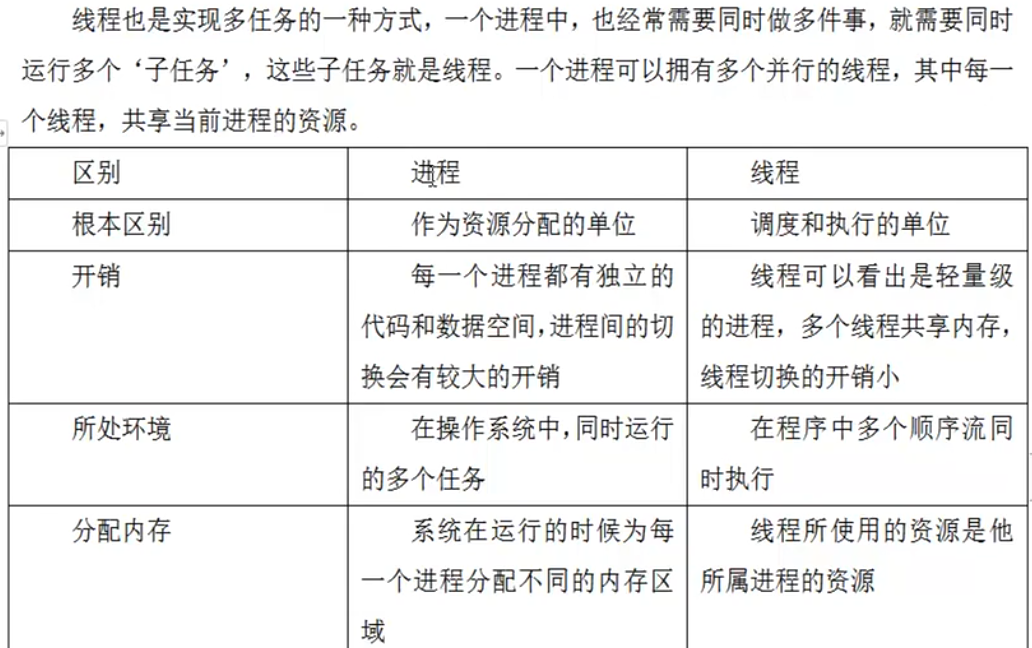

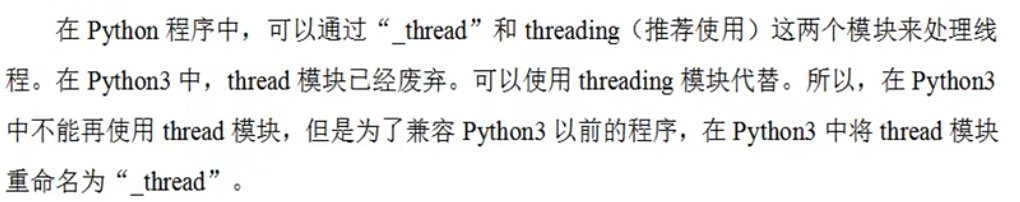

## multiprocessing.dummy 模块
multiprocessing.dummy 复制了 multiprocessing 的 API，不过是在 threading 模块之上包装了一层。

只需要将multiprocessing换成multiprocessing.dummy，就可以将程序从多进程改为多线程了。

## threading
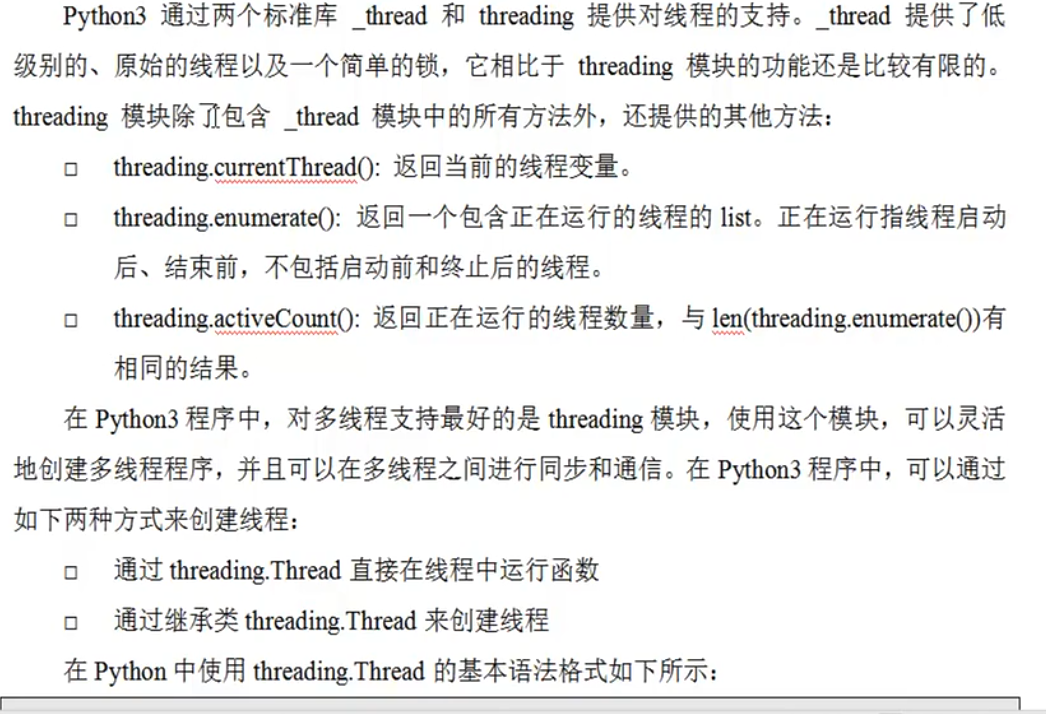

In [69]:
import threading

In [66]:
from threading import Thread

In [ ]:
Thread(
    group=None,
    target=None,
    name=None,
    args=(),
    kwargs=None,
    *,
    daemon=None,
)

In [70]:
def run_proc(a, age, **kwargs):
    print(a,age, kwargs)
    print(threading.current_thread().getName())
    print('线程运行中...')
    
t = Thread(target=run_proc, args=('a1',12,), kwargs={'key1':12})

t.start()

a1 12 {'key1': 12}
Thread-27
线程运行中...


## 使用继承方式创建线程

In [71]:
#export
class ClockThread(Thread):
    def __init__(self, interval):
        Thread.__init__(self)
        self.interval = interval
    def run(self):
        print('子线程开始')
        sleep(self.interval)
        print('子线程结束')

In [72]:
p = ClockThread(2)
p.start()
p.join()
print('主进程结束')

子线程开始
子线程结束
主进程结束


## 线程间共享变量
在一个进程内所有线程共享全局变量，多线程之间的数据共享比多进程要好。

但是可能造成多个进程同时修改一个变量(即线程非安全)，可能造成混乱

In [74]:
num = 1
def work1():
    global num
    num += 5
    print('子进程1运行，num:', num)
def work2():
    global num
    num += 10
    print('子进程2运行，num:', num)
    
print('父进程开始运行')
p1 = Thread(target=work1)
p2 = Thread(target=work2)
p1.start()
p2.start()
p1.join()
p2.join()

print(num)  # 主进程和子进程间的数据是不共享的

父进程开始运行
子进程1运行，num:子进程2运行，num: 16
 6
16


## 互斥锁
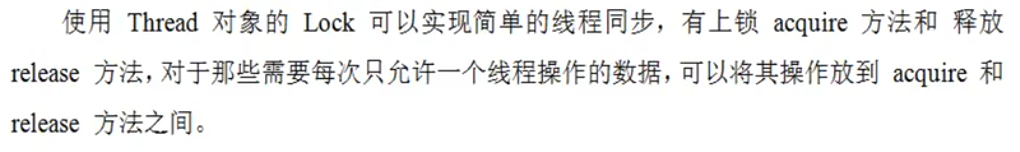

In [75]:
from threading import Thread, Lock

In [84]:
num = 0
mutex = Lock()
def test1():
    global num
    # 如果两个线程都调用上锁的方法，则会抢着上锁，如果1方成功上锁，会导致另一方阻塞，知道这个锁被释放
    
    for i in range(1000000):
        mutex.acquire()
        num += 1
        mutex.release()
    print(num)
def test2():
    global num
    for i in range(1000000):
        mutex.acquire()
        num += 1
        mutex.release()
    print(num)
    
t1 = Thread(target=test1)
t2 = Thread(target=test2)
t1.start()
t2.start()
t1.join()
t2.join()

1825190
2000000


## 线程同步

In [88]:
lock1, lock2, lock3 = Lock(), Lock(), Lock()
lock2.acquire()
lock3.acquire()

class Task1(Thread):
    def run(self):
        while True:
            if lock1.acquire():
                print('task1...')
                sleep(1)
                lock2.release()
class Task2(Thread):
    def run(self):
        while True:
            if lock2.acquire():
                print('task2...')
                sleep(1)
                lock3.release()
class Task3(Thread):
    def run(self):
        while True:
            if lock3.acquire():
                print('task3...')
                sleep(1)
                lock1.release()
                
t1 = Task1()    
t2 = Task2()    
t3 = Task3()  
t1.start()
t2.start()
t3.start()
# t1.join()
# t2.join()
# t3.join()

task1...
task2...
task3...
task1...
task2...
task3...
task1...
task2...
task3...
task1...


# 生产者消费者模式
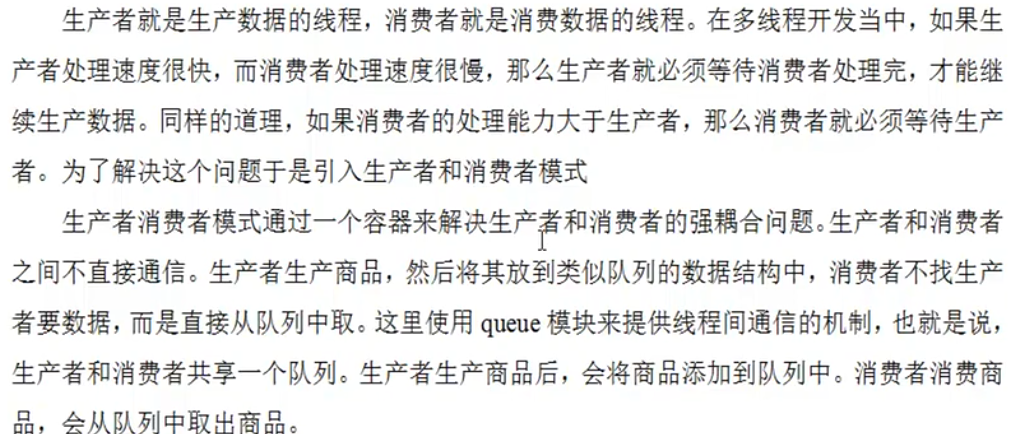

In [1]:
from queue import Queue
import time
import threading

In [3]:
class Producer(threading.Thread):
    def run(self):
        global queue
        count = 0
        while True:
            if queue.qsize()<1000:
                for i in range(100):
                    count += 1
                    msg = f'生成产品{count}'
                    queue.put(msg)
                    print(msg)
            time.sleep(0.5)
class Consumer(threading.Thread):
    def run(self):
        global queue
        count = 0
        while True:
            if queue.qsize()>100:
                for i in range(3):
                    count += 1
                    msg = f'{self.name}消费{queue.get()}'
                    print(msg)
            time.sleep(1)                    
                    
queue = Queue()
p = Producer()
p.start()
c = Consumer()
c.start()

生成产品1
生成产品2
生成产品3
生成产品4
生成产品5
生成产品6
生成产品7
生成产品8
生成产品9
生成产品10
生成产品11
生成产品12
生成产品13
生成产品14
生成产品15
生成产品16
生成产品17
生成产品18
生成产品19
生成产品20
生成产品21
生成产品22
生成产品23
生成产品24
生成产品25
生成产品26
生成产品27
生成产品28
生成产品29
生成产品30
生成产品31
生成产品32
生成产品33
生成产品34
生成产品35
生成产品36
生成产品37
生成产品38
生成产品39
生成产品40
生成产品41
生成产品42
生成产品43
生成产品44
生成产品45
生成产品46
生成产品47
生成产品48
生成产品49
生成产品50
生成产品51
生成产品52
生成产品53
生成产品54
生成产品55
生成产品56
生成产品57
生成产品58
生成产品59
生成产品60
生成产品61
生成产品62
生成产品63
生成产品64
生成产品65
生成产品66
生成产品67
生成产品68
生成产品69
生成产品70
生成产品71
生成产品72
生成产品73
生成产品74
生成产品75
生成产品76
生成产品77
生成产品78
生成产品79
生成产品80
生成产品81
生成产品82
生成产品83
生成产品84
生成产品85
生成产品86
生成产品87
生成产品88
生成产品89
生成产品90
生成产品91
生成产品92
生成产品93
生成产品94
生成产品95
生成产品96
生成产品97
生成产品98
生成产品99
生成产品100
生成产品101
生成产品102
生成产品103
生成产品104
生成产品105
生成产品106
生成产品107
生成产品108
生成产品109
生成产品110
生成产品111
生成产品112
生成产品113
生成产品114
生成产品115
生成产品116
生成产品117
生成产品118
生成产品119
生成产品120
生成产品121
生成产品122
生成产品123
生成产品124
生成产品125
生成产品126
生成产品127
生成产品128
生成产品129
生成产品130
生成产品131
生成产品132
生成产品133
生成产品134
生成产品135
生成产品136
生成产品137
生成产品138
生成产品

Thread-7消费生成产品16
Thread-7消费生成产品17
Thread-7消费生成产品18
Thread-7消费生成产品19
Thread-7消费生成产品20
Thread-7消费生成产品21
Thread-7消费生成产品22
Thread-7消费生成产品23
Thread-7消费生成产品24
Thread-7消费生成产品25
Thread-7消费生成产品26
Thread-7消费生成产品27
Thread-7消费生成产品28
Thread-7消费生成产品29
Thread-7消费生成产品30
Thread-7消费生成产品31
Thread-7消费生成产品32
Thread-7消费生成产品33
Thread-7消费生成产品34
Thread-7消费生成产品35
Thread-7消费生成产品36
Thread-7消费生成产品37
Thread-7消费生成产品38
Thread-7消费生成产品39
Thread-7消费生成产品40
Thread-7消费生成产品41
Thread-7消费生成产品42
Thread-7消费生成产品43
Thread-7消费生成产品44
Thread-7消费生成产品45
Thread-7消费生成产品46
Thread-7消费生成产品47
Thread-7消费生成产品48
Thread-7消费生成产品49
Thread-7消费生成产品50
Thread-7消费生成产品51
Thread-7消费生成产品52
Thread-7消费生成产品53
Thread-7消费生成产品54
Thread-7消费生成产品55
Thread-7消费生成产品56
Thread-7消费生成产品57
Thread-7消费生成产品58
Thread-7消费生成产品59
Thread-7消费生成产品60
Thread-7消费生成产品61
Thread-7消费生成产品62
Thread-7消费生成产品63
Thread-7消费生成产品64
Thread-7消费生成产品65
Thread-7消费生成产品66
Thread-7消费生成产品67
Thread-7消费生成产品68
Thread-7消费生成产品69
Thread-7消费生成产品70
Thread-7消费生成产品71
Thread-7消费生成产品72
Thread-7消费生成产品73
Thread-7消费生成产品

# ThreadLocal
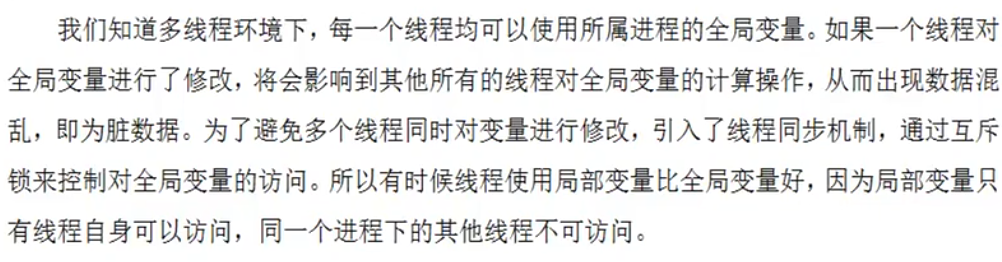

In [1]:
import threading

In [4]:
# 创建全局的ThreadLocal对象
local = threading.local()

def process_student():
    # 获取当前关联的name
    stu_name = local.name
    print(f'线程名:{threading.current_thread().name}, 学生名: {stu_name}')
    
def process_thread(name):
    # 绑定ThreadLocal的name
    local.name = name
    process_student()
    
t1 = threading.Thread(target=process_thread, args=('zhangsan',), name='Thread-A')
t2 = threading.Thread(target=process_thread, args=('lisi',), name='Thread-B')
t1.start()
t2.start()

线程名:Thread-A, 学生名: zhangsan线程名:Thread-B, 学生名: lisi



# 示例
https://mp.weixin.qq.com/s/2gT5e_uJ--USCleLmvzZ8g

## 查找网页信息

In [1]:
import urllib.request as urllib2
from multiprocessing.dummy import Pool as ThreadPool
from multiprocessing import Pool
import time

In [2]:
def t(num, mode='thread'):
    start = time.time()
    urls = [
         'http://www.python.org' ,
         'http://www.python.org/about/' ,
         'http://www.onlamp.com/pub/a/python/2003/04/17/metaclasses.html' ,
         'http://www.python.org/doc/' ,
         'http://www.python.org/download/' ,
         'http://www.python.org/getit/' ,
         'http://www.python.org/community/' ,
         'https://wiki.python.org/moin/' ,
         'http://planet.python.org/' ,
         'https://wiki.python.org/moin/LocalUserGroups' ,
         'http://www.python.org/psf/' ,
         'http://docs.python.org/devguide/' ,
         'http://www.python.org/community/awards/'
        # etc..
        ]

    # Make the Pool of workers
    if mode=='thread':
        pool = ThreadPool(num)
    else:
        pool = Pool(num)
    # Open the urls in their own threads
    # and return the results
    results = pool.map(urllib2.urlopen, urls)
    #close the pool and wait for the work to finish
    pool.close()
    pool.join()
    print(time.time()-start)

In [19]:
t(1)

10.343959093093872


In [15]:
t(4)

4.207953929901123


In [24]:
t(4, mode='process')

MaybeEncodingError: Error sending result: '[<http.client.HTTPResponse object at 0x10c2fed30>]'. Reason: 'TypeError("cannot serialize '_io.BufferedReader' object")'

In [16]:
t(8)

3.045103073120117


In [17]:
t(20)

2.6625308990478516


In [18]:
t(40)

2.572591781616211


## 生成上千张图片的缩略图 
这是一个 CPU 密集型的任务，并且十分适合进行并行化。

### 基础单进程版本

In [ ]:
import os
import PIL

from multiprocessing import Pool
from PIL import Image

SIZE = (75,75)
SAVE_DIRECTORY =  thumbs

def get_image_paths(folder):
    return (os.path.join(folder, f)
            for f in os.listdir(folder)
            if  jpeg  in f)

def create_thumbnail(filename): 
    im = Image.open(filename)
    im.thumbnail(SIZE, Image.ANTIALIAS)
    base, fname = os.path.split(filename)
    save_path = os.path.join(base, SAVE_DIRECTORY, fname)
    im.save(save_path)

if __name__ ==  __main__ :
    folder = os.path.abspath(
         11_18_2013_R000_IQM_Big_Sur_Mon__e10d1958e7b766c3e840 )
    os.mkdir(os.path.join(folder, SAVE_DIRECTORY))

    images = get_image_paths(folder)

    for image in images:
        create_thumbnail(Image)

### 使用 map 函数来代替 for 循环

In [ ]:
import os
import PIL

from multiprocessing import Pool
from PIL import Image

SIZE = (75,75)
SAVE_DIRECTORY =  thumbs

def get_image_paths(folder):
    return (os.path.join(folder, f)
            for f in os.listdir(folder)
            if  jpeg  in f)

def create_thumbnail(filename): 
    im = Image.open(filename)
    im.thumbnail(SIZE, Image.ANTIALIAS)
    base, fname = os.path.split(filename)
    save_path = os.path.join(base, SAVE_DIRECTORY, fname)
    im.save(save_path)

if __name__ ==  __main__ :
    folder = os.path.abspath(
         11_18_2013_R000_IQM_Big_Sur_Mon__e10d1958e7b766c3e840 )
    os.mkdir(os.path.join(folder, SAVE_DIRECTORY))

    images = get_image_paths(folder)

    pool = Pool()
    pool.map(creat_thumbnail, images)
    pool.close()
    pool.join()

# nb_export

In [4]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted engineering_nbdev.ipynb.
Converted index.ipynb.


In [7]:
!nbdev_build_docs

No notebooks were modified
converting /Users/luoyonggui/PycharmProjects/nbdevlib/index.ipynb to README.md
